In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#data_load
def data_load():
  songs = pd.read_csv('/content/drive/My Drive/music/songs.csv')
  transactions = pd.read_csv('/content/drive/My Drive/music/transactions.csv')
  train = pd.read_csv('/content/drive/My Drive/music/train.csv')
  test = pd.read_csv('/content/drive/My Drive/music/test.csv')
  return songs, transactions, train, test

In [0]:
def bar_chart(feature):
  male = train_merge[train_merge['gender']=='male'][feature].value_counts()
  female = train_merge[train_merge['gender']=='female'][feature].value_counts()
  dfs = pd.DataFrame([male,female])
  dfs.index = ['male','female']
  dfs.plot(kind='bar',stacked=True, figsize=(10,5))

In [0]:
def cross_tab(x1,x2):
  return pd.crosstab(x1, x2, margins=True) #genre: 남녀 비슷

In [0]:
def min_max(df, feature):
  df[feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())

In [0]:
songs, transactions, train, test = data_load()

In [7]:
print('data_shape')
print('songs : ', songs.shape)
print('transactions : ', transactions.shape)
print('train : ', train.shape)
print('test : ', test.shape)

data_shape
songs :  (4878, 8)
transactions :  (1819855, 6)
train :  (7000, 7)
test :  (1679, 7)


In [0]:
song_tran = pd.merge(transactions, songs, on = 'song_id', how='left')

In [9]:
song_tran.tail()

,user_id,song_id,rec_loc,rec_screen,entry,listen,length,genre,artist,composer,lyricist,language,isrc
1819850,6273,6415,my library,Local playlist more,local-library,0,282447,465,554,1787,2013,3,TWB730110001
1819851,4505,8831,my library,Local playlist more,local-library,0,279510,458,727,1373,1321,3,TWD951643211
1819852,682,1921,radio,Radio,radio,0,250357,465,872,1576,1564,3,MYPN11313101
1819853,12056,7586,search,Artist more,top-hits-for-artist,0,257462,465,500,824,780,3,GTTA31205008
1819854,9505,889,my library,Local playlist more,local-library,1,276480,921,391,525,1419,3,TWD951564103


In [111]:
song_tran['artist'].unique().shape

(943,)

In [10]:
a = song_tran.groupby('user_id')['listen'].agg({'listen_sum':'sum'}).reset_index()
train_merge = pd.merge(train, a, on='user_id' ,how='left')
l = song_tran.groupby('user_id')['length'].agg({'leng':'mean'}).reset_index()
train_merge = pd.merge(train_merge, l, on='user_id' ,how='left')
#로그 기록이 없는 사람은 음악감상을 이용하지 않은 사람 0으로 채움
train_merge['listen_sum'] = train_merge['listen_sum'].fillna(0).astype(int)
train_merge['leng'] = train_merge['leng'].fillna(0)

#loc 사용 종류
rec_loc = song_tran.groupby('user_id')['rec_loc'].agg({'rec_loc_num':'nunique'}).reset_index()
#screen 사용 종류
rec_screen = song_tran.groupby('user_id')['rec_screen'].agg({'rec_screen_num':'nunique'}).reset_index()
#language
language = song_tran.groupby('user_id')['language'].agg({'language':'nunique'}).reset_index()
#rec_loc, rec_screen 붙이기
train_merge = train_merge.merge(rec_screen, on='user_id', how='left')
train_merge = train_merge.merge(rec_loc, on = 'user_id',how='left')
train_merge = train_merge.merge(language, on='user_id', how='left')
train_merge = train_merge.fillna(0)
train_merge['rec_screen_num'] = train_merge['rec_screen_num'].astype('int')
train_merge['rec_loc_num'] = train_merge['rec_loc_num'].astype('int')
train_merge['language'] = train_merge['language'].astype('int')

#genre, lyricist, composer 최빈값

#genre = song_tran.groupby('user_id')['genre'].agg(lambda x:x.value_counts().index[0]).reset_index()
composer = song_tran.groupby('user_id')['composer'].agg(lambda x:x.value_counts().index[0]).reset_index()
lyricist = song_tran.groupby('user_id')['lyricist'].agg(lambda x:x.value_counts().index[0]).reset_index()
artist = song_tran.groupby('user_id')['artist'].agg(lambda x:x.value_counts().index[0]).reset_index()


#train_merge = train_merge.merge(genre, on ='user_id',how='left')
train_merge = train_merge.merge(composer, on ='user_id',how='left')
train_merge = train_merge.merge(lyricist, on ='user_id',how='left')
train_merge = train_merge.merge(artist, on='user_id', how='left')
train_merge = train_merge.fillna(0)
#train_merge['genre'] = train_merge['genre'].astype('int')
train_merge['composer'] = train_merge['composer'].astype('int')
train_merge['lyricist'] = train_merge['lyricist'].astype('int')
train_merge['artist'] = train_merge['artist'].astype('int')

#등록-만료 기간 계산
train_merge['reg_date'] = pd.to_datetime(train_merge['reg_date'], format='%Y%m%d')
train_merge['ex_date'] = pd.to_datetime(train_merge['ex_date'], format='%Y%m%d')
train_merge['duration'] = (train_merge['ex_date'] - train_merge['reg_date']).dt.days
#등록, 만료 날짜 지우기
train_merge = train_merge.drop(['reg_date','ex_date'], axis=1)
#들은 횟수, duration min_max scaling
min_max(train_merge,'listen_sum')
min_max(train_merge, 'duration')

#age 그룹 나누기
train_merge.loc[ train_merge['age'] <= 19, 'age'] = 0
train_merge.loc[(train_merge['age'] > 19) & (train_merge['age'] <= 40), 'age'] = 1
train_merge.loc[(train_merge['age'] > 40) & (train_merge['age'] <= 50), 'age'] = 2
train_merge.loc[ train_merge['age'] > 50, 'age'] = 3
train_merge['age'] = train_merge['age'].astype('int')
#length 구간 나누기
train_merge.loc[ train_merge['leng'] <= 223515, 'leng'] = 0
train_merge.loc[(train_merge['leng'] > 223515) & (train_merge['leng'] <= 249835), 'leng'] = 1
train_merge.loc[(train_merge['leng'] > 249835) & (train_merge['leng'] <= 275644), 'leng'] = 2
train_merge.loc[ train_merge['leng'] > 275644, 'leng'] = 3
train_merge['leng'] = train_merge['leng'].astype('int')

genre = pd.pivot_table(song_tran, index='user_id', columns='song_id', values='genre')
genre = genre.fillna(0).astype('int')
train_merge = train_merge.merge(genre, on='user_id', how='left')
train_merge = train_merge.fillna(0)





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we loa

In [11]:
a = song_tran.groupby('user_id')['listen'].agg({'listen_sum':'sum'}).reset_index()
test_merge = pd.merge(test, a, on='user_id' ,how='left')
l = song_tran.groupby('user_id')['length'].agg({'leng':'mean'}).reset_index()
test_merge = pd.merge(test_merge, l, on='user_id' ,how='left')
#로그 기록이 없는 사람은 음악감상을 이용하지 않은 사람 0으로 채움
test_merge['listen_sum'] = test_merge['listen_sum'].fillna(0).astype(int)
test_merge['leng'] = test_merge['leng'].fillna(0)

#loc 사용 종류
rec_loc = song_tran.groupby('user_id')['rec_loc'].agg({'rec_loc_num':'nunique'}).reset_index()
#screen 사용 종류
rec_screen = song_tran.groupby('user_id')['rec_screen'].agg({'rec_screen_num':'nunique'}).reset_index()
#language
language = song_tran.groupby('user_id')['language'].agg({'language':'nunique'}).reset_index()
#rec_loc, rec_screen 붙이기
test_merge = test_merge.merge(rec_screen, on='user_id', how='left')
test_merge = test_merge.merge(rec_loc, on = 'user_id',how='left')
test_merge = test_merge.merge(language, on='user_id', how='left')
test_merge = test_merge.fillna(0)
test_merge['rec_screen_num'] = test_merge['rec_screen_num'].astype('int')
test_merge['rec_loc_num'] = test_merge['rec_loc_num'].astype('int')
test_merge['language'] = test_merge['language'].astype('int')

#genre, lyricist, composer 최빈값

#genre = song_tran.groupby('user_id')['genre'].agg(lambda x:x.value_counts().index[0]).reset_index()
composer = song_tran.groupby('user_id')['composer'].agg(lambda x:x.value_counts().index[0]).reset_index()
lyricist = song_tran.groupby('user_id')['lyricist'].agg(lambda x:x.value_counts().index[0]).reset_index()
artist = song_tran.groupby('user_id')['artist'].agg(lambda x:x.value_counts().index[0]).reset_index()


#train_merge = train_merge.merge(genre, on ='user_id',how='left')
test_merge = test_merge.merge(composer, on ='user_id',how='left')
test_merge = test_merge.merge(lyricist, on ='user_id',how='left')
test_merge = test_merge.merge(artist, on='user_id', how='left')
test_merge = test_merge.fillna(0)
#train_merge['genre'] = train_merge['genre'].astype('int')
test_merge['composer'] = test_merge['composer'].astype('int')
test_merge['lyricist'] = test_merge['lyricist'].astype('int')
test_merge['artist'] = test_merge['artist'].astype('int')

#등록-만료 기간 계산
test_merge['reg_date'] = pd.to_datetime(test_merge['reg_date'], format='%Y%m%d')
test_merge['ex_date'] = pd.to_datetime(test_merge['ex_date'], format='%Y%m%d')
test_merge['duration'] = (test_merge['ex_date'] - test_merge['reg_date']).dt.days
#등록, 만료 날짜 지우기
test_merge = test_merge.drop(['reg_date','ex_date'], axis=1)
#들은 횟수, duration min_max scaling
min_max(test_merge,'listen_sum')
min_max(test_merge, 'duration')

#age 그룹 나누기
test_merge.loc[ test_merge['age'] <= 19, 'age'] = 0
test_merge.loc[(test_merge['age'] > 19) & (test_merge['age'] <= 40), 'age'] = 1
test_merge.loc[(test_merge['age'] > 40) & (test_merge['age'] <= 50), 'age'] = 2
test_merge.loc[ test_merge['age'] > 50, 'age'] = 3
test_merge['age'] = test_merge['age'].astype('int')
#length 구간 나누기
test_merge.loc[ test_merge['leng'] <= 223515, 'leng'] = 0
test_merge.loc[(test_merge['leng'] > 223515) & (test_merge['leng'] <= 249835), 'leng'] = 1
test_merge.loc[(test_merge['leng'] > 249835) & (test_merge['leng'] <= 275644), 'leng'] = 2
test_merge.loc[ test_merge['leng'] > 275644, 'leng'] = 3
test_merge['leng'] = test_merge['leng'].astype('int')

genre = pd.pivot_table(song_tran, index='user_id', columns='song_id', values='genre')
genre = genre.fillna(0).astype('int')
test_merge = test_merge.merge(genre, on='user_id', how='left')
test_merge = test_merge.fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we loa

In [12]:
train_merge.head()

,user_id,city,age,reg_method,gender,listen_sum,leng,rec_screen_num,rec_loc_num,language,composer,lyricist,artist,duration,0,2,5,6,7,11,12,14,18,19,22,24,25,26,27,28,29,32,36,37,38,39,41,43,44,45,...,9553,9555,9556,9557,9558,9559,9561,9563,9566,9567,9569,9570,9571,9572,9573,9574,9579,9581,9587,9588,9593,9599,9604,9607,9610,9611,9613,9616,9621,9622,9623,9625,9629,9633,9634,9635,9636,9637,9642,9643
0,13827,14,1,9,female,0.088378,1,3,2,4,1387,1576,500,0.358905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6618,13,0,4,female,0.070218,1,8,5,5,827,989,391,0.128957,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7615,22,1,9,female,0.031477,2,5,4,4,1856,1898,676,0.819188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15535,13,2,9,female,0.100484,1,7,4,4,1844,1248,112,0.461449,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17708,18,1,4,female,0.016949,1,4,2,1,1657,1672,727,0.059817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
test_merge.head()

,user_id,city,age,reg_method,gender,listen_sum,leng,rec_screen_num,rec_loc_num,language,composer,lyricist,artist,duration,0,2,5,6,7,11,12,14,18,19,22,24,25,26,27,28,29,32,36,37,38,39,41,43,44,45,...,9553,9555,9556,9557,9558,9559,9561,9563,9566,9567,9569,9570,9571,9572,9573,9574,9579,9581,9587,9588,9593,9599,9604,9607,9610,9611,9613,9616,9621,9622,9623,9625,9629,9633,9634,9635,9636,9637,9642,9643
0,16169,13,1,3,0.0,0.030449,1,2,2,2,2144,2184,895,0.461264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4694,13,0,3,0.0,0.096955,2,6,4,5,1384,1576,499,0.199524,0.0,465.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,458.0,465.0,0.0,458.0,465.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10654,1,0,3,0.0,0.022436,0,5,3,4,627,477,112,0.212800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9327,14,0,4,0.0,0.142628,2,6,2,5,1384,2094,446,0.079849,0.0,465.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,0.0,458.0,465.0,0.0,458.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3631,22,1,9,0.0,0.093750,2,4,3,3,1384,1576,772,0.524074,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
test.head()

,user_id,city,age,reg_method,reg_date,ex_date,gender
0,16169,13,21,3,20120118,20180604,NaN
1,4694,13,0,3,20150110,20171014,NaN
2,10654,1,18,3,20150402,20180312,NaN
3,9327,14,16,4,20160824,20171002,NaN
4,3631,22,26,9,20100927,20171225,NaN


In [78]:
song_tran['isrc'].str[:2].unique()

array(['JP', 'TW', 'HK', 'GB', 'KR', 'CN', 'US', 'NO', 'NL', 'DE', 'QM',
       'SG', 'MY', 'TG', 'GT', 'CA', 'SE', 'NG', 'TH', 'EM', 'DK', 'AU',
       'MO', 'FR', 'TC', 'UK', 'CY', 'GL'], dtype=object)

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Activation, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from tensorflow.keras.models import Model, load_model, Sequential

In [0]:
#gender mapping
train_merge.gender = train_merge.gender.map({'male': 0, 'female': 1})
#학습데이터 만들기
train_data = train_merge.drop(['user_id','gender'], axis=1)
train_label = train_merge['gender']

In [0]:
test_data = test_merge.drop(['user_id','gender'], axis=1)

In [25]:
test_data.head()

,city,age,reg_method,listen_sum,leng,rec_screen_num,rec_loc_num,language,composer,lyricist,artist,duration,0,2,5,6,7,11,12,14,18,19,22,24,25,26,27,28,29,32,36,37,38,39,41,43,44,45,46,48,...,9553,9555,9556,9557,9558,9559,9561,9563,9566,9567,9569,9570,9571,9572,9573,9574,9579,9581,9587,9588,9593,9599,9604,9607,9610,9611,9613,9616,9621,9622,9623,9625,9629,9633,9634,9635,9636,9637,9642,9643
0,13,1,3,0.030449,1,2,2,2,2144,2184,895,0.461264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1609.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,0,3,0.096955,2,6,4,5,1384,1576,499,0.199524,0.0,465.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,458.0,465.0,0.0,458.0,465.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,3,0.022436,0,5,3,4,627,477,112,0.212800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,0,4,0.142628,2,6,2,5,1384,2094,446,0.079849,0.0,465.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,465.0,0.0,0.0,458.0,465.0,0.0,458.0,0.0,0.0,0.0,458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,1,9,0.093750,2,4,3,3,1384,1576,772,0.524074,0.0,465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
train_data.shape

(7000, 4889)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.1)

In [19]:
model = Sequential()
model.add(Dense(1024, input_dim = train_data.shape[1] ,activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              5008384   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,603,009
Trainable params: 5,603,009
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(x_train, y_train, batch_size=16, epochs=30)

Epoch 1/30
394/394 [==============================] - 3s 7ms/step - loss: 5.2499 - accuracy: 0.5356
Epoch 2/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5178 - accuracy: 0.8108
Epoch 3/30
394/394 [==============================] - 3s 7ms/step - loss: 0.2445 - accuracy: 0.9203
Epoch 4/30
394/394 [==============================] - 3s 7ms/step - loss: 0.1877 - accuracy: 0.9530
Epoch 5/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5262 - accuracy: 0.8859
Epoch 6/30
394/394 [==============================] - 3s 7ms/step - loss: 0.2322 - accuracy: 0.9363
Epoch 7/30
394/394 [==============================] - 3s 7ms/step - loss: 0.1279 - accuracy: 0.9648
Epoch 8/30
394/394 [==============================] - 3s 7ms/step - loss: 0.1601 - accuracy: 0.9606
Epoch 9/30
394/394 [==============================] - 3s 7ms/step - loss: 0.1118 - accuracy: 0.9675
Epoch 10/30
394/394 [==============================] - 3s 7ms/step - loss: 0.1028 - accuracy: 0.9705

In [0]:
pred = model.predict(x_test)

In [0]:
pred1 = np.where(pred > 0.5, 1, 0)

In [0]:
pred1 = pred1.reshape(1400,)

In [158]:
np.mean(pred1 == y_test)

0.5892857142857143

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

In [23]:
roc_auc_score(y_test, pred)

0.6014471437092965

In [0]:
fpr, tpr, thres = roc_curve(y_test, pred)

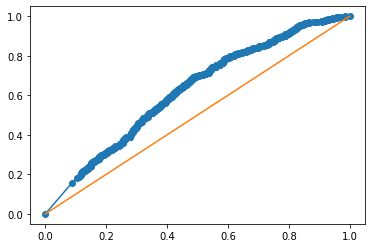

In [144]:
plt.plot(fpr, tpr, 'o-', label="DNN")
plt.plot([0,1],[0,1], label='s')
plt.show()

In [0]:
test_gender = model.predict(test_data)

In [0]:
test['gender'] = test_gender

In [28]:
test.head()

,user_id,city,age,reg_method,reg_date,ex_date,gender
0,16169,13,21,3,20120118,20180604,0.246497
1,4694,13,0,3,20150110,20171014,0.948936
2,10654,1,18,3,20150402,20180312,0.002010
3,9327,14,16,4,20160824,20171002,0.000004
4,3631,22,26,9,20100927,20171225,1.000000


In [0]:
test.to_csv('gender_pred_DL.csv')